# Machine Learning Complements Project
# IMDb Movies Recommender System and Genre Prediction
### G5 - Veronija Kodovska, Maria Fain and Fabijan Bošnjak

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import json
import nltk
import random
from datetime import datetime, timedelta
from pathlib import Path
import xgboost as xgb
#nltk.download('stopwords')
import re
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from recommenders.datasets.python_splitters import python_stratified_split
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from scipy.sparse import csr_matrix, find
from scipy.sparse.linalg import svds
from surprise import SVD, Reader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, accuracy_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

In [185]:
movies = pd.read_csv("data\movies_metadata.csv", sep = ',', low_memory=False)

In [92]:
#ratings = pd.read_csv("data/ratings.csv", sep = ',', low_memory=False)
#for a more fast run you can load the smaller dataset right away
ratings_small = pd.read_csv("data/ratings_smaller.csv")

In [19]:
movies.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

We will be using two datasets - movies and ratings, one with information about movies from IMDb which will be used for genre prediction and the other, containing the same movies with ratings from users which will be used for building a recommender system which we will merge after preprocessing the data.

In [186]:
#delete unnecessary columns
movies = movies.drop(['belongs_to_collection', 'adult', 'budget', 'original_language', 'popularity', 
                'poster_path', 'production_companies', 'production_countries', 'revenue', 'runtime', 
                'spoken_languages', 'status', 'tagline', 'video', 'vote_average', 'vote_count', 'homepage',
                'imdb_id', 'release_date', 'original_title'], axis=1)
movies = movies.rename(columns={'id': 'movieId'})
movies

,genres,movieId,overview,title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...",Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Just when George Banks has recovered from his ...,Father of the Bride Part II
...,...,...,...,...
45461,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,Rising and falling between a man and woman.,Subdue
45462,"[{'id': 18, 'name': 'Drama'}]",111109,An artist struggles to finish his work while a...,Century of Birthing
45463,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",67758,"When one of her hits goes wrong, a professiona...",Betrayal
45464,[],227506,"In a small town live two brothers, one a minis...",Satan Triumphant


The features we will be using from dataset 1 are:
 - genres &ndash; an array with the id and name of genres which we will transform
 - movieId &ndash; movie id
 - overview &ndash; a text description of the movie
 - title &ndash; title of the movie

In [21]:
movies.describe()

,genres,movieId,overview,title
count,45465,45465,44511,45459
unique,4069,45435,44306,42276
top,"[{'id': 18, 'name': 'Drama'}]",141971,No overview found.,Cinderella
freq,5000,3,133,11


In [9]:
print(ratings.columns)
ratings

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')


,userId,movieId,rating,timestamp
0,1,110,1.0,1425941529
1,1,147,4.5,1425942435
2,1,858,5.0,1425941523
3,1,1221,5.0,1425941546
4,1,1246,5.0,1425941556
...,...,...,...,...
26024284,270896,58559,5.0,1257031564
26024285,270896,60069,5.0,1257032032
26024286,270896,63082,4.5,1257031764
26024287,270896,64957,4.5,1257033990


The features we will be using from dataset 2 are:
 - userId &ndash; id of the user who gave the review
 - movieId &ndash; id of the movie the user rated
 - rating &ndash; a rating on a 5-star scale with half-star increments (0.5 - 5 stars)
 - timestamp

In [8]:
ratings.describe()

,userId,movieId,rating,timestamp
count,2.602429e+07,2.602429e+07,2.602429e+07,2.602429e+07
mean,1.350371e+05,1.584911e+04,3.528090e+00,1.171258e+09
std,7.817620e+04,3.108526e+04,1.065443e+00,2.052889e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,6.716400e+04,1.073000e+03,3.000000e+00,9.907545e+08
50%,1.351630e+05,2.583000e+03,3.500000e+00,1.151716e+09
75%,2.026930e+05,6.503000e+03,4.000000e+00,1.357578e+09
max,2.708960e+05,1.762750e+05,5.000000e+00,1.501830e+09


Since the ratings dataset is quite large and was giving us trouble with memory and certain functions, we decided to decrease it's size. Firstly, we will transform the timestamps to ISO format and then sort the dataset chronologically. Then we will take the first 1 000 000 rows and use this dataset going forward. We also exported the smaller dataset to a .csv file for easier uploads and faster testing.

In [9]:
ratings['timestamp'] = ratings.apply(
    lambda x: datetime.strftime(datetime(1970, 1, 1, 0, 0, 0) + timedelta(seconds=x['timestamp'].item()), "%Y-%m-%d %H:%M:%S"), 
    axis=1)
ratings = ratings.sort_values('timestamp').reset_index(drop=True)
ratings

,userId,movieId,rating,timestamp
0,38150,1176,4.0,1995-01-09 11:46:44
1,44717,1079,3.0,1995-01-09 11:46:49
2,44717,47,5.0,1995-01-09 11:46:49
3,44717,21,3.0,1995-01-09 11:46:49
4,190860,21,5.0,1996-01-29 00:00:00
...,...,...,...,...
26024284,85434,3210,2.0,2017-08-04 06:38:59
26024285,85434,82169,3.0,2017-08-04 06:39:06
26024286,85434,1013,4.0,2017-08-04 06:41:23
26024287,199634,60040,3.0,2017-08-04 06:53:43


In [10]:
#if you have loaded the smaller dataset right away you can comment this section
ratings_small = ratings.iloc[:1000000,:]
filepath = Path('ratings_smaller.csv')
filepath.parent.mkdir(parents=True, exist_ok=True)  
ratings_small.to_csv(index=False, path_or_buf=filepath)

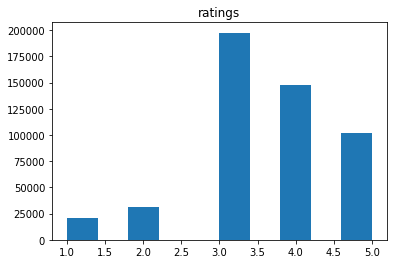

In [167]:
plt.hist(ratings_small['rating'])
plt.title('ratings')
plt.show()

We see that we have a class imbalance between the higher rated movies and the lower rated ones.

In [187]:
#checking for empty values
print(movies.isna().sum())
print(ratings_small.isna().sum())

genres        0
movieId       0
overview    954
title         6
dtype: int64
userId     0
movieId    0
rating     0
dtype: int64


In [188]:
#remove movies without titles
movies.drop(movies[movies['title'].isna()].index, inplace=True)
#remove movies without overview or with no overwievs found
movies.drop(movies[movies['overview'].isna()].index, inplace=True)
movies.drop(movies[movies['overview'] == ''].index, inplace=True)
movies.drop(movies[movies['overview'] == 'No overview found.'].index, inplace=True)

In [189]:
#checking for empty values
print(movies.isna().sum())
print(ratings_small.isna().sum())

genres      0
movieId     0
overview    0
title       0
dtype: int64
userId     0
movieId    0
rating     0
dtype: int64


In [190]:
#remove movies without specified genres
movies.drop(movies[movies['genres'] == '[]'].index, inplace=True)
movies

,genres,movieId,overview,title
0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",862,"Led by Woody, Andy's toys live happily in his ...",Toy Story
1,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",8844,When siblings Judy and Peter discover an encha...,Jumanji
2,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",15602,A family wedding reignites the ancient feud be...,Grumpier Old Men
3,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",31357,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,"[{'id': 35, 'name': 'Comedy'}]",11862,Just when George Banks has recovered from his ...,Father of the Bride Part II
...,...,...,...,...
45459,"[{'id': 878, 'name': 'Science Fiction'}]",222848,It's the year 3000 AD. The world's most danger...,Caged Heat 3000
45460,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",30840,"Yet another version of the classic epic, with ...",Robin Hood
45461,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",439050,Rising and falling between a man and woman.,Subdue
45462,"[{'id': 18, 'name': 'Drama'}]",111109,An artist struggles to finish his work while a...,Century of Birthing


In [191]:
#convert genres from json to a list of strings
genres = []
for i in movies['genres']:
    gList = str.split(i, sep='\'name\': \'')
    for j in range(1, len(gList)):
        gList[j] = gList[j].split('\'')[0]
    gList.pop(0)
    genres.append(gList)
    
movies['genres'] = genres
movies

,genres,movieId,overview,title
0,"[Animation, Comedy, Family]",862,"Led by Woody, Andy's toys live happily in his ...",Toy Story
1,"[Adventure, Fantasy, Family]",8844,When siblings Judy and Peter discover an encha...,Jumanji
2,"[Romance, Comedy]",15602,A family wedding reignites the ancient feud be...,Grumpier Old Men
3,"[Comedy, Drama, Romance]",31357,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,[Comedy],11862,Just when George Banks has recovered from his ...,Father of the Bride Part II
...,...,...,...,...
45459,[Science Fiction],222848,It's the year 3000 AD. The world's most danger...,Caged Heat 3000
45460,"[Drama, Action, Romance]",30840,"Yet another version of the classic epic, with ...",Robin Hood
45461,"[Drama, Family]",439050,Rising and falling between a man and woman.,Subdue
45462,[Drama],111109,An artist struggles to finish his work while a...,Century of Birthing


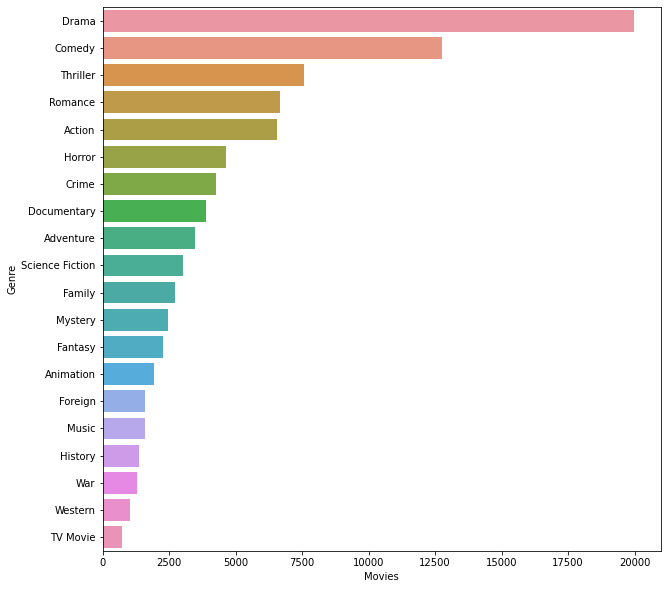

In [192]:
#barplot unique genres
allGenres = sum(genres, [])
allGenres = nltk.FreqDist(allGenres) 

genresDf = pd.DataFrame({'Genre': list(allGenres.keys()), 
                         'Movies': list(allGenres.values())})

plt.figure(figsize=(10,10)) 
sns.barplot(data=genresDf, x="Movies", y="Genre", order=genresDf.sort_values('Movies', ascending=False).Genre) 
plt.show()

It is clear from the plot that there are some genres that are represented in very little numbers and when inspected more closely, don't seem to resemble actual genre names but production company names. We will drop them from the dataset.

In [193]:
nonGenres = ['Carousel Productions', 'Vision View Entertainment', 'Telescene Film Group Productions', 
            'Aniplex', 'GoHands', 'BROSTA TV', 'Mardock Scramble Production Committee', 'Sentai Filmworks',
            'Odyssey Media', 'Pulser Productions', 'Rogue State', 'The Cartel']
movieIds = [] 
for index, row in movies.iterrows():
    for g in row['genres']:
        if g in nonGenres:
            movieIds.append(row['movieId'])
for mId in movieIds:
    movies.drop(movies[movies['movieId'] == mId].index, inplace=True)

movies

,genres,movieId,overview,title
0,"[Animation, Comedy, Family]",862,"Led by Woody, Andy's toys live happily in his ...",Toy Story
1,"[Adventure, Fantasy, Family]",8844,When siblings Judy and Peter discover an encha...,Jumanji
2,"[Romance, Comedy]",15602,A family wedding reignites the ancient feud be...,Grumpier Old Men
3,"[Comedy, Drama, Romance]",31357,"Cheated on, mistreated and stepped on, the wom...",Waiting to Exhale
4,[Comedy],11862,Just when George Banks has recovered from his ...,Father of the Bride Part II
...,...,...,...,...
45459,[Science Fiction],222848,It's the year 3000 AD. The world's most danger...,Caged Heat 3000
45460,"[Drama, Action, Romance]",30840,"Yet another version of the classic epic, with ...",Robin Hood
45461,"[Drama, Family]",439050,Rising and falling between a man and woman.,Subdue
45462,[Drama],111109,An artist struggles to finish his work while a...,Century of Birthing


After a closer look, we realized these rows were loaded in a wrong way. Since the data loss is not big and we couldn't find a cause of this wrong load, we decided to remove them as they would created noise.

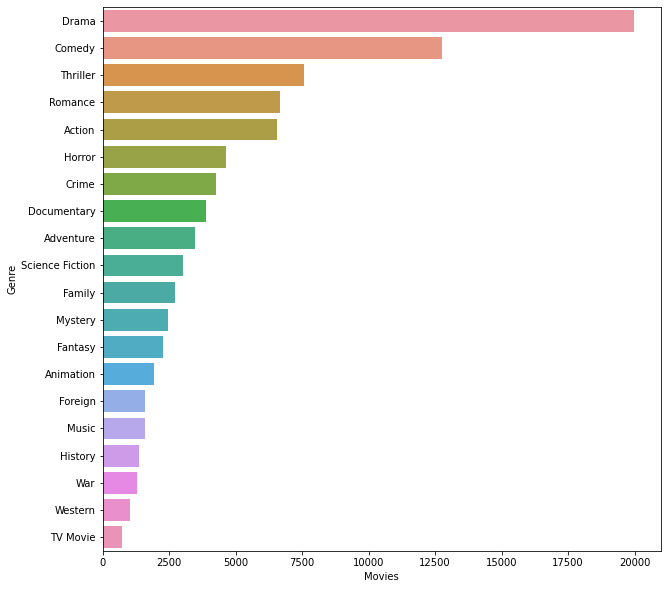

In [194]:
#barplot unique genres again
genres = []
for r in movies['genres']:
    genres.append(r)
    
allGenres = sum(genres, [])
allGenres = nltk.FreqDist(allGenres) 

genresDf = pd.DataFrame({'Genre': list(allGenres.keys()), 
                         'Movies': list(allGenres.values())})

plt.figure(figsize=(10,10)) 
sns.barplot(data=genresDf, x="Movies", y="Genre", order=genresDf.sort_values('Movies', ascending=False).Genre) 
plt.show()

The code bellow cleans the text in the movies['overview'] column by removing unnecessary characters and converting the text to lowercase which can be useful for natural language processing (NLP) tasks such as text classification or sentiment analysis.

In [206]:
#Clean data
def cleanPlot(plot):
    ps = PorterStemmer()
    sw = set(stopwords.words('english'))
    plot = re.sub("\'", "", plot) 
    plot = re.sub("[^a-zA-Z]"," ", plot)
    plot = ' '.join(plot.split()) 
    plot = plot.lower() 
    return plot

movies['overview'] = movies['overview'].apply(lambda x: cleanPlot(x))
movies.head()

,genres,movieId,overview,title
0,"[Animation, Comedy, Family]",862,led woody andy toy live happili room andy birt...,Toy Story
1,"[Adventure, Fantasy, Family]",8844,when sibl judi peter discov enchant board game...,Jumanji
2,"[Romance, Comedy]",15602,a famili wed reignit ancient feud next door ne...,Grumpier Old Men
3,"[Comedy, Drama, Romance]",31357,cheat on mistreat step on women hold breath wa...,Waiting to Exhale
4,[Comedy],11862,just georg bank recov daughter wedding receiv ...,Father of the Bride Part II


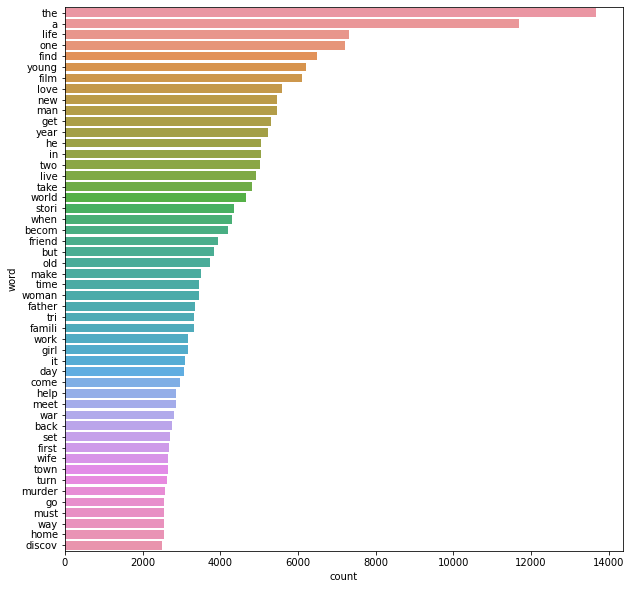

In [207]:
#visualise most frequent words
def freqWords(x, maxWords): 
  allWords = ' '.join([text for text in x]) 
  allWords = allWords.split() 
  fdist = nltk.FreqDist(allWords) 
  wordsDf = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
  
  d = wordsDf.nlargest(columns="count", n = maxWords) 

  plt.figure(figsize=(10,10)) 
  sns.barplot(data=d, x= "count", y = "word") 
  plt.show()
  
freqWords(movies['overview'], 50)

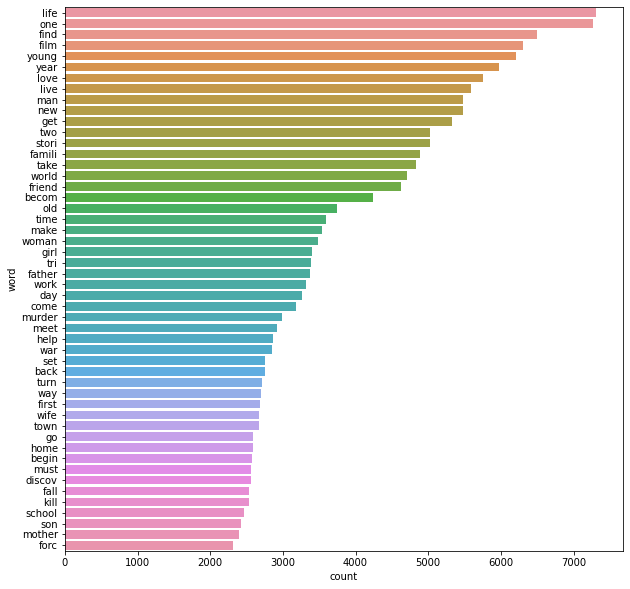

In [208]:
#Remove stopwords, apply stemming and visualize
stopWords = set(stopwords.words('english'))
ps = PorterStemmer()

def removeStopwordsAndStem(plot):
    stemmedNoStopwordPlot = [ps.stem(w) for w in plot.split() if not w in stopWords]
    return ' '.join(stemmedNoStopwordPlot)

movies['overview'] = movies['overview'].apply(lambda x: removeStopwordsAndStem(x))
freqWords(movies['overview'], 50)

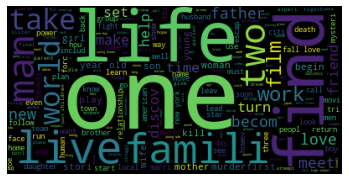

In [209]:
#word cloud visualization
corpus = []
for overview in movies['overview']:
    corpus.append(overview)

wordcloud = WordCloud().generate(" ".join(corpus))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [210]:
movies.describe()

,genres,movieId,overview,title
count,42198,42198,42198,42198
unique,4041,42168,42126,39262
top,[Drama],141971,,Cinderella
freq,4892,3,11,10


After cleaning the overview, some overviews were left empty because of removing stop words so we will remove those as well.

In [211]:
movies.drop(movies[movies['overview'] == ''].index, inplace=True)
movies.describe()

,genres,movieId,overview,title
count,42187,42187,42187,42187
unique,4041,42157,42125,39252
top,[Drama],141971,overview yet,Cinderella
freq,4890,3,3,10


We noticed the overview "overview yet" also is not an actual overview so we will delete that as well.

In [212]:
movies.drop(movies[movies['overview'] == 'overview yet'].index, inplace=True)
movies.describe()

,genres,movieId,overview,title
count,42184,42184,42184,42184
unique,4041,42154,42124,39249
top,[Drama],141971,recov nail gun shot head month coma doctor pek...,Cinderella
freq,4890,3,3,10


Finally, we have our movies dataset that we will use for genre prediction.

In [216]:
#we will delete the movie with id 31357 because we will use it to test our models on unseen data
movies.drop(movies[movies['movieId'] == '31357'].index, inplace=True)
movies

,genres,movieId,overview,title
0,"[Animation, Comedy, Family]",862,led woodi andi toy live happili room andi birt...,Toy Story
1,"[Adventure, Fantasy, Family]",8844,sibl judi peter discov enchant board game open...,Jumanji
2,"[Romance, Comedy]",15602,famili wed reignit ancient feud next door neig...,Grumpier Old Men
4,[Comedy],11862,georg bank recov daughter wed receiv news preg...,Father of the Bride Part II
5,"[Action, Crime, Drama, Thriller]",949,obsess master thief neil mccauley lead top not...,Heat
...,...,...,...,...
45459,[Science Fiction],222848,year ad world danger women banish remot astero...,Caged Heat 3000
45460,"[Drama, Action, Romance]",30840,yet anoth version classic epic enough variat m...,Robin Hood
45461,"[Drama, Family]",439050,rise fall man woman,Subdue
45462,[Drama],111109,artist struggl finish work storylin cult play ...,Century of Birthing


## Text classification
 The following code performs genre classification for movies based on their plots using a **logistic regression**, **random forest and naive bayes** models and TF-IDF vectorization. By following this approach, the code allows for the classification of movie genres based on their plot descriptions. The reported classification scores provide a measure of the model's overall performance, while the prediction for "Die Hard" showcases the practical application of the trained model to infer genres for new movies.

In [217]:
#Convert each genre to separate binary class
multilabelBinarizer = MultiLabelBinarizer()
multilabelBinarizer.fit(movies['genres'])

#output class
y = multilabelBinarizer.transform(movies['genres'])
y

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 1, 0, 0]])

In [218]:
#Extract top 10000 most frequent words from plots
tfidfVectorizer = TfidfVectorizer(max_features=10000)

xTrain, xTest, yTrain, yTest = train_test_split(movies['overview'], y, test_size=0.2, random_state=9)

xTrainTfidf = tfidfVectorizer.fit_transform(xTrain)
xTestTfidf = tfidfVectorizer.transform(xTest)

Since we had a problem with empty predictions, we realized in some cases the threshold for choosing which class to predict is lower than 0.5 (the default one). That is why we made a function which chooses the class with the max predicted probability.

In [219]:
def get_pred_labels(model):  
    y_pred_proba = model.predict_proba(xTestTfidf)
    y_pred_labels = model.predict(xTestTfidf)
    for i in range(len(y_pred_labels)):
        if y_pred_labels[i].sum() == 0:
            max_idx = np.argmax(y_pred_proba[i])
            y_pred_labels[i][max_idx] = 1
    return y_pred_labels

In [220]:
#Train and test the model with logistic regression
lr = LogisticRegression(max_iter=10000)
classifier_lr = OneVsRestClassifier(lr)

classifier_lr.fit(xTrainTfidf, yTrain)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=10000))

In [221]:
#Predict and get evaluation metrics scores
yPred_lr = get_pred_labels(classifier_lr)

print('True value:')
print(yTest[1])
print(multilabelBinarizer.inverse_transform(yTest)[1])

print('Predicted value: ')
print(yPred_lr[1])
print(multilabelBinarizer.inverse_transform(yPred_lr)[1])

print('Evaluation Scores using logistic regression: ')
print(classification_report(yTest, yPred_lr, zero_division=1))

True value:
[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0]
('Action', 'Fantasy', 'Thriller')
Predicted value: 
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
('Fantasy',)
Evaluation Scores using logistic regression: 
              precision    recall  f1-score   support

           0       0.70      0.39      0.50      1269
           1       0.66      0.15      0.24       686
           2       0.88      0.16      0.28       374
           3       0.67      0.52      0.58      2530
           4       0.64      0.23      0.34       858
           5       0.86      0.56      0.68       775
           6       0.68      0.79      0.73      4060
           7       0.81      0.15      0.26       547
           8       0.67      0.11      0.19       441
           9       1.00      0.00      0.00       341
          10       0.30      0.01      0.02       246
          11       0.83      0.43      0.56       930
          12       0.63      0.18      0.28       326
          13       0.52      0.09   

For an example of prediction we see our logistic regression model predicts one of the genres correctly for the given example but failed to predict the other one, we will take it as a win.

We get a high score of precision and low scores for recall and f1-metric because we have a lot of negative cases, namely we have a lot of classes so there will be many more zeroes in our predictions than ones which affects recall and therefore affects f1-score. This problem is a problem of class imbalance and it would be good to try how a one vs one approach would work on these examples.

In [222]:
#Custom test for Logistic Regression

#Waiting to Exhale (Comedy, Drama, Romance)
#we already cleaned the plot
plotList = ['cheat mistreat step women hold breath wait elu good man break string less stellar lover friend confid vannah berni glo robin talk determin find better way breath']
plotListTfidf = tfidfVectorizer.transform(plotList)

pred = classifier_lr.predict(plotListTfidf)
if pred[0].sum() == 0:
    proba = classifier_lr.predict_proba(plotListTfidf)
    max_idx = np.argmax(proba)
    pred[0][max_idx] = 1

print(pred)
print(multilabelBinarizer.inverse_transform(pred))

[[0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[('Comedy', 'Drama')]


Our logistic regression model did pretty good on this unseen example by predicting 2/3 genres correctly.

In [223]:
#Train and test the model with Random Forest 

rf = RandomForestClassifier(n_estimators=50)
classifier_rf = OneVsRestClassifier(rf)

classifier_rf.fit(xTrainTfidf, yTrain)

OneVsRestClassifier(estimator=RandomForestClassifier(n_estimators=50))

In [224]:
#Predict and get evaluation metrics scores
yPred_rf = get_pred_labels(classifier_rf)

print('True value:')
print(yTest[1])
print(multilabelBinarizer.inverse_transform(yTest)[1])

print('Predicted value: ')
print(yPred_rf[1])
print(multilabelBinarizer.inverse_transform(yPred_rf)[1])

print('Evaluation Scores using logistic regression: ')
print(classification_report(yTest, yPred_rf, zero_division=1))

True value:
[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0]
('Action', 'Fantasy', 'Thriller')
Predicted value: 
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
('Drama',)
Evaluation Scores using logistic regression: 
              precision    recall  f1-score   support

           0       0.72      0.20      0.31      1269
           1       0.49      0.05      0.09       686
           2       0.73      0.19      0.31       374
           3       0.68      0.35      0.47      2530
           4       0.59      0.09      0.15       858
           5       0.85      0.44      0.58       775
           6       0.62      0.84      0.71      4060
           7       0.77      0.09      0.15       547
           8       0.49      0.05      0.09       441
           9       0.23      0.03      0.06       341
          10       0.14      0.01      0.02       246
          11       0.75      0.31      0.44       930
          12       0.61      0.07      0.13       326
          13       0.29      0.01     

In [225]:
#Custom test for Random Forest

#Waiting to Exhale (Comedy, Drama, Romance)
#we already cleaned the plot
plotList = ['cheat mistreat step women hold breath wait elu good man break string less stellar lover friend confid vannah berni glo robin talk determin find better way breath']
newPlotsTfidf = tfidfVectorizer.transform(plotList)

pred = classifier_rf.predict(newPlotsTfidf)
if pred[0].sum() == 0:
    proba = classifier_rf.predict_proba(newPlotsTfidf)
    max_idx = np.argmax(proba)
    pred[0][max_idx] = 1

print(pred)
print(multilabelBinarizer.inverse_transform(pred))

[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[('Drama',)]


In [226]:
# Train and test the model with Naive Bayes

naiveBayes = MultinomialNB()
classifier_nb = OneVsRestClassifier(naiveBayes)

classifier_nb.fit(xTrainTfidf, yTrain)

OneVsRestClassifier(estimator=MultinomialNB())

In [227]:
#Predict and get evaluation metrics scores
yPred_nb = get_pred_labels(classifier_nb)

print('True value:')
print(yTest[1])
print(multilabelBinarizer.inverse_transform(yTest)[1])

print('Predicted value: ')
print(yPred_nb[1])
print(multilabelBinarizer.inverse_transform(yPred_nb)[1])

print('Evaluation Scores using logistic regression: ')
print(classification_report(yTest, yPred_nb, zero_division=1))

True value:
[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0]
('Action', 'Fantasy', 'Thriller')
Predicted value: 
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
('Drama',)
Evaluation Scores using logistic regression: 
              precision    recall  f1-score   support

           0       0.73      0.28      0.41      1269
           1       0.78      0.06      0.12       686
           2       0.88      0.02      0.04       374
           3       0.68      0.38      0.49      2530
           4       0.65      0.03      0.07       858
           5       0.86      0.35      0.50       775
           6       0.61      0.88      0.72      4060
           7       0.82      0.04      0.08       547
           8       0.91      0.02      0.04       441
           9       1.00      0.00      0.00       341
          10       1.00      0.00      0.00       246
          11       0.90      0.25      0.39       930
          12       0.83      0.02      0.03       326
          13       1.00      0.00     

In [228]:
#Custom test for Naive Bayes

#Waiting to Exhale (Comedy, Drama, Romance)
#we already cleaned the plot
plotList = ['cheat mistreat step women hold breath wait elu good man break string less stellar lover friend confid vannah berni glo robin talk determin find better way breath']
newPlotsTfidf = tfidfVectorizer.transform(plotList)

pred = classifier_nb.predict(newPlotsTfidf)
if pred[0].sum() == 0:
    proba = classifier_nb.predict_proba(newPlotsTfidf)
    max_idx = np.argmax(proba)
    pred[0][max_idx] = 1

print(pred)
print(multilabelBinarizer.inverse_transform(pred))

[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[('Drama',)]


## Cross validation
To evaluate the model's performance, we employed 5-fold cross-validation. This means that the dataset was split into five subsets or "folds." The model was trained and tested five times, with each fold serving as the test set once while the remaining folds were used for training. We used a classification report containing precision, recall and F1-score, which measures the model's accuracy in capturing the presence or absence of each genre.

In [229]:
# Convert each genre to separate binary class for a movie
multilabelBinarizer = MultiLabelBinarizer()
multilabelBinarizer.fit(movies['genres'])

# Output class
y = multilabelBinarizer.transform(movies['genres'])

# Extract top 10000 most frequent words from plots
tfidfVectorizer = TfidfVectorizer(max_features=10000)

# Transform the entire dataset
xTfidf = tfidfVectorizer.fit_transform(movies['overview'])

# Train and test the model with cross-validation
lr = LogisticRegression(max_iter=10000)
clf = OneVsRestClassifier(lr)

scores = cross_val_score(clf, xTfidf, y, cv=5, scoring='f1_samples')  # Perform 5-fold cross-validation

print('Cross-Validation F1 Scores:', scores)
print('Average F1 Score:', scores.mean())

Cross-Validation F1 Scores: [0.43331934 0.46458535 0.4573134  0.45172014 0.45168862]
Average F1 Score: 0.4517253731467907


In [231]:
#Waiting to Exhale (Comedy, Drama, Romance)
#we already cleaned the plot
plotList = ['cheat mistreat step women hold breath wait elu good man break string less stellar lover friend confid vannah berni glo robin talk determin find better way breath']
plotListTfidf = tfidfVectorizer.transform(plotList)

# Fit the classifier on the entire dataset before making predictions
clf.fit(xTfidf, y)

pred = clf.predict(plotListTfidf)
if pred[0].sum() == 0:
    proba = clf.predict_proba(plotListTfidf)
    max_idx = np.argmax(proba)
    pred[0][max_idx] = 1

print('\nPrediction for "Waiting to Exhale":')
print(pred)
print(multilabelBinarizer.inverse_transform(pred))


Prediction for "Waiting to Exhale":
[[0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]]
[('Comedy', 'Drama')]


## Movie Recommender System

The next component is building a movie recommender system based on the ratings dataset.

To help with the common recommender system problem known as cold-start that is caused by lack of starting information, we will work with users that have at least 20 ratings. We will also reduce the size of our dataset to 500 000 rows.

In [93]:
ratings_small = ratings_small.iloc[:500000,:]

In [94]:
user_ratings_count = ratings_small.groupby(['userId', 'movieId']).size().groupby('userId').size()
print('Number of users: %d' % len(user_ratings_count))
users_with_20_ratings = user_ratings_count[user_ratings_count >= 20].reset_index()[['userId']]
print('Number of users with at least 20 ratings: ', len(users_with_20_ratings))

Number of users: 10916
Number of users with at least 20 ratings:  8125


In [95]:
#drop duplicates
ratings_small = ratings_small.drop_duplicates()

We will be dropping the column timestamp.

In [96]:
ratings_small = ratings_small.drop(['timestamp'], axis=1)

Now, we will merge the movies and ratings dataset (we will only take the movie title column from the movies dataset).

In [97]:
movies_titles = movies.drop(['overview', 'genres'], axis=1)
ratings_small['movieId'] = ratings_small['movieId'].astype(str)
merged = pd.merge(movies_titles, ratings_small, on='movieId', how='inner')
#rearrange columns
merged = merged[['userId', 'movieId', 'rating', 'title']]
merged

,userId,movieId,rating,title
0,9767,710,2.0,GoldenEye
1,145809,710,3.0,GoldenEye
2,43338,710,3.0,GoldenEye
3,43389,710,4.0,GoldenEye
4,249365,710,1.0,GoldenEye
...,...,...,...,...
397505,255712,286,2.0,Germany: A Summer's Fairytale
397506,142455,286,2.0,Germany: A Summer's Fairytale
397507,89182,286,2.0,Germany: A Summer's Fairytale
397508,177535,286,2.0,Germany: A Summer's Fairytale


### Splitting data to test and train sets

To ensure generalization of previously unseen data, cross-validation will be used. Data is split into two data sets - one for training (70%) and one for testing (30%). In our case of recommending movies to users, to make sure the evaluation is statisically sound, the same set of users for both model building and testing should be used (to avoid any cold-ness of users), and a stratified splitting strategy should be taken, as oppose in other cases where a chronological split would be a better fit.
We also set a minimum of 20 ratings per user so the number of rows in the dataset is likely to change. 

In [98]:
#splitting the data
ratings_train, ratings_test = python_stratified_split(
    merged, filter_by="user", min_rating=20, ratio=0.7,
    col_user='userId', col_item='movieId'
)

In [103]:
ratings_train.shape

(244961, 4)

In [104]:
ratings_test.shape

(105113, 4)

In [105]:
#number of rows changes
rows_new = ratings_train.shape[0] + ratings_test.shape[0]
print('Number of rows after splitting the data and applying the filter: ' + str(rows_new))
print('Number of original rows: ' + str(ratings_small.shape[0]))

Number of rows after splitting the data and applying the filter: 350074
Number of original rows: 500000


In [106]:
#remove "cold" users from test set  
ratings_test = ratings_test[ratings_test.userId.isin(ratings_train.userId)]
print('Number of rows after removing cold users from test set: ' + str(rows_new))
print('Number of original rows: ' + str(ratings_small.shape[0]))

Number of rows after removing cold users from test set: 350074
Number of original rows: 500000


### Matrix factorization

Recommender systems use utility matrixes to store user-item data. These matrixes are characterized by their sparsity which poses as one of the biggest challenges in recommender systems. We will be filling the missing values in the utility matrix with zeroes. Note that this does not mean that the users have given those items a rating of zero, it simply means they have not rated it (yet).

In [107]:
#creating a sparse pivot table with users in rows and movies in columns - the utility matrix
utility_matrix_train = ratings_train.pivot(index='userId', columns='movieId', values='rating').fillna(0)

utility_matrix_train

movieId,100,101,102,103,104,105,106,107,108,109,...,87,88,89,90,92,93,95,96,97,99
userId,,,,,,,,,,,,,,,,,,,,,
80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0


In [108]:
utility_matrix_test = ratings_test.pivot(index='userId', columns='movieId', values='rating').fillna(0)

utility_matrix_test

movieId,100,101,102,103,104,105,107,108,109,11,...,87,88,89,90,92,93,95,96,98,99
userId,,,,,,,,,,,,,,,,,,,,,
80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0


In [109]:
#compressed sparse row matrix
sparse_matrix_train = csr_matrix(utility_matrix_train)
sparse_matrix_test = csr_matrix(utility_matrix_test)

In [110]:
def get_rated_items(user_id, dataset):
    ranked_items = dataset.loc[user_id]['movieId']
    return set(ranked_items if type(ranked_items) == pd.Series else [ranked_items])

Next, we did a bit of preprocessing. Our model combines a content based and collaborative filtering approach. To find the similarity between movies we will use the cosine similarity function, this is our content based method. For the collaborative filtering method, we will use a matrix factorization technique - SVD.

First, SVD. Singular Value Decomposition decomposes the utility matrix M ($m \times n$) in the following form: $ SVD (M) = U \times S \times V^{T} $
Where U is a $m \times r$ orthogonal left singular matrix, which represents the relationship between users and latent factors, S is a $r \times r$ diagonal matrix, which describes the strength of each latent factor and V is a $r \times n$ diagonal right singular matrix, which indicates the similarity between items and latent factors. The SVD decreases the dimension of the utility matrix M by extracting its latent factors. It maps each user and each item into a r-dimensional latent space. This mapping facilitates a clear representation of relationships between users and items. 

For implementing SVD we used Python's Surprise and converted our data to train sets, a format of data Surprise accepts and works with. The predictions we got will be used as a feature of the final data that will go into our model as the collaborative filtering component.

In [122]:
#reader = Reader(rating_scale=(1, 5))
#param_grid = {"n_epochs": [5, 10], "lr_all": [0.002, 0.005], "reg_all": [0.4, 0.6]}
#gs = GridSearchCV(SVD, param_grid, cv=3, scoring='precision')

#data = Dataset.load_from_df(merged[["userId", "movieId", "rating"]], reader)
#gs.fit(data)

# combination of parameters that gave the best RMSE score
#print(gs.best_params)

In [123]:
#{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}

model_SVD = SVD(n_epochs=10, lr_all=0.005, reg_all=0.4)
# create the traindata from the dataframe
train_data_mf = Dataset.load_from_df(ratings_train[["userId", "movieId", "rating"]], reader)

# build the trainset from traindata
trainset = train_data_mf.build_full_trainset()

#do the same for the test set
test_data_mf = Dataset.load_from_df(ratings_test[["userId", "movieId", "rating"]], reader)
testset = test_data_mf.build_full_trainset()

#train the model
model_SVD.fit(trainset)

In [124]:
train_preds = model_SVD.test(trainset.build_testset())
train_pred_mf = np.array([pred.est for pred in train_preds])
test_preds = model_SVD.test(testset.build_testset())
test_pred_mf = np.array([pred.est for pred in test_preds])

In [125]:
y_true = []
y_pred = []
for t in train_preds:
    y_true.append(t[2])
    y_pred.append(t[3])
print('RMSE train: ', mean_squared_error(y_true, y_pred, squared=False))

RMSE train:  0.8534782060438596


In [126]:
y_true = []
y_pred = []
for t in test_preds:
    y_true.append(t[2])
    y_pred.append(t[3])
print('RMSE test: ', mean_squared_error(y_true, y_pred, squared=False))

RMSE test:  0.8726465403186591


We will be using the previously created sparse matrix on our train and test data to calculate the global rating average and use it as a feature to our final data.

In [127]:
def get_global_avg(sparse_matrix):
    avgs = {}
    avgs['global'] = sparse_matrix.sum() / sparse_matrix.count_nonzero()
    return avgs

In [128]:
train_avgs = get_global_avg(sparse_matrix_train)
test_avgs = get_global_avg(sparse_matrix_test)

Next, let’s create a function which takes the sparse matrix as input and gives the average ratings of a movie given by all users, and the average rating of all movies given by a single user.

In [129]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)
def get_average_ratings(sparse_m, of_users):# average ratings of user/axes
    # 1 - User axes,0 - Movie axes
    ax = 1 if of_users else 0 
    # ".A1" is for converting Column_Matrix to 1-D numpy array
    sum_of_ratings = sparse_m.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_m != 0
    # number of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1
    # max_user and max_movie ids in sparse matrix
    u, m = sparse_m.shape
    
    average_ratings = dict()
    for i in range(u if of_users else m):
        if no_of_ratings[i] != 0:
            average_ratings[i] = sum_of_ratings[i] / no_of_ratings[i]
            
    return average_ratings

In [130]:
train_avgs['user'] = get_average_ratings(sparse_matrix_train, of_users=True)
train_avgs['movie'] = get_average_ratings(sparse_matrix_train, of_users=False)
test_avgs['user'] = get_average_ratings(sparse_matrix_test, of_users=True)
test_avgs['movie'] = get_average_ratings(sparse_matrix_test, of_users=False)

In [131]:
# get users, movies and ratings from the sparse matrix
train_users, train_movies, train_ratings = find(sparse_matrix_train)
test_users, test_movies, test_ratings = find(sparse_matrix_test)

In [132]:
def get_final_data(users, movies, ratings, sparse_m, avgs, pred_mf):
    final_data = pd.DataFrame()
    count = 0
    start = datetime.now()
    for (user, movie, rating) in zip(users, movies, ratings):
        #--------------------- Ratings of "movie" by similar users of "user" ---------------------
        # compute the similar Users of the "user"     
        user_sim = cosine_similarity(sparse_m[user], sparse_m).ravel()
        top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
        # get the ratings of most similar users for this movie
        top_ratings = sparse_m[top_sim_users, movie].toarray().ravel()
        # we will make it's length "5" by adding movie averages to .
        top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
        top_sim_users_ratings.extend([avgs['movie'][movie]]*(5 - len(top_sim_users_ratings)))  

        #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
        # compute the similar movies of the "movie"        
        movie_sim = cosine_similarity(sparse_m[:,movie].T, sparse_m.T).ravel()
        top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
        # get the ratings of most similar movie rated by this user..
        top_ratings = sparse_m[user, top_sim_movies].toarray().ravel()
        # we will make it's length "5" by adding user averages to.
        top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
        top_sim_movies_ratings.extend([avgs['user'][user]]*(5-len(top_sim_movies_ratings))) 

        #-----------------prepare the row to be stores in a file-----------------#
        row = list()
        row.append(user)
        row.append(movie)

        row.append(avgs['global']) # first feature
        row.extend(top_sim_users_ratings)
        row.extend(top_sim_movies_ratings)
        row.append(avgs['user'][user])
        row.append(avgs['movie'][movie])
        row.append(rating)
        count = count + 1
        final_data = final_data.append([row])

        if (count)%10000 == 0:
            #break

            print("Done for {} rows. Time passed: {}".format(count, datetime.now() - start))
                    
    final_data.columns=['userId', 'movieId', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
            'smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating']
    #final_data['mf_svd'] = train_pred_mf
    final_data['mf_svd'] = pred_mf
    print('Final time passed: {}'.format(datetime.now() - start))
    
    return final_data

The function for getting the final data computes 5 most similar users to a single user using cosine similarity and gets their ratings of the movie for the user-movie pair. It does the same thing for the 5 most similar movies rated by the user and gets their ratings.

In [133]:
final_data_train = get_final_data(train_users, train_movies, train_ratings, sparse_matrix_train, train_avgs, train_pred_mf)
print(final_data_train.shape)
final_data_train

Done for 10000 rows. Time passed: 0:02:19.577449
Done for 20000 rows. Time passed: 0:04:45.979731
Done for 30000 rows. Time passed: 0:07:09.963595
Done for 40000 rows. Time passed: 0:09:36.744035
Done for 50000 rows. Time passed: 0:12:08.287789
Done for 60000 rows. Time passed: 0:14:42.020843
Done for 70000 rows. Time passed: 0:17:19.949210
Done for 80000 rows. Time passed: 0:19:59.811043
Done for 90000 rows. Time passed: 0:22:44.661824
Done for 100000 rows. Time passed: 0:25:31.006329
Done for 110000 rows. Time passed: 0:28:21.314813
Done for 120000 rows. Time passed: 0:31:34.493990
Done for 130000 rows. Time passed: 0:34:49.040751
Done for 140000 rows. Time passed: 0:38:10.065268
Done for 150000 rows. Time passed: 0:41:37.895842
Done for 160000 rows. Time passed: 0:45:10.129813
Done for 170000 rows. Time passed: 0:48:40.058589
Done for 180000 rows. Time passed: 0:52:11.032124
Done for 190000 rows. Time passed: 0:55:45.908112
Done for 200000 rows. Time passed: 0:59:22.867292
Done for 

,userId,movieId,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,mf_svd
0,15,0,3.538812,3.0,4.0,3.0,4.0,3.0,2.0,5.0,5.0,5.0,4.0,3.800000,3.308140,3.0,3.101853
0,71,0,3.538812,3.0,2.0,3.0,3.0,4.0,3.0,4.0,5.0,4.0,5.0,3.979592,3.308140,2.0,3.926299
0,181,0,3.538812,3.0,3.0,4.0,4.0,4.0,2.0,4.0,3.0,3.0,1.0,2.756522,3.308140,3.0,3.689029
0,210,0,3.538812,3.0,4.0,3.0,4.0,3.0,5.0,5.0,4.0,3.0,5.0,3.816092,3.308140,3.0,3.857768
0,236,0,3.538812,4.0,3.0,4.0,3.0,4.0,5.0,4.0,2.0,4.0,3.0,3.345679,3.308140,4.0,4.269093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,5931,572,3.538812,3.0,3.0,4.0,1.0,1.0,2.0,3.0,1.0,2.0,1.0,2.553073,2.586207,3.0,3.823064
0,6838,572,3.538812,2.0,4.0,1.0,3.0,1.0,5.0,3.0,3.0,5.0,5.0,3.611111,2.586207,1.0,4.342593
0,6984,572,3.538812,4.0,3.0,2.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,1.819209,2.586207,1.0,4.135075
0,7150,572,3.538812,1.0,2.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,3.0,3.382353,2.586207,2.0,3.788079


Here is a better explanation of the new features: 
- GAvg &ndash; the global average - average rating of all movies rated by all users
- sur &ndash; top 5 similar user ratings of the movie for the user-movie pair (row) 
- smr &ndash; top 5 similar movie ratings of the movie for the user-movie pair (row) 
- UAvg &ndash; user average rating
- MAvg &ndash; movie average rating
- mf_svd &ndash; the SVD predictions calculated previously

In [134]:
final_data_test = get_final_data(test_users, test_movies, test_ratings, sparse_matrix_test, test_avgs, test_pred_mf)
print(final_data_test.shape)
final_data_test

Done for 10000 rows. Time passed: 0:00:59.303791
Done for 20000 rows. Time passed: 0:02:29.974233
Done for 30000 rows. Time passed: 0:03:49.012483
Done for 40000 rows. Time passed: 0:05:10.888479
Done for 50000 rows. Time passed: 0:07:00.952796
Done for 60000 rows. Time passed: 0:08:54.447833
Done for 70000 rows. Time passed: 0:10:55.018405
Done for 80000 rows. Time passed: 0:12:54.791215
Done for 90000 rows. Time passed: 0:14:32.322684
Done for 100000 rows. Time passed: 0:16:43.019495
Final time passed: 0:17:52.446643
(105113, 17)


,userId,movieId,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,mf_svd
0,91,0,3.54351,3.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,4.0,3.0,3.250000,3.506329,3.0,3.476106
0,116,0,3.54351,3.0,3.0,3.0,3.0,2.0,3.0,4.0,3.0,4.0,5.0,4.000000,3.506329,5.0,3.433153
0,178,0,3.54351,5.0,3.0,4.0,3.0,5.0,5.0,4.0,5.0,2.0,4.0,4.052632,3.506329,5.0,3.378500
0,339,0,3.54351,4.0,4.0,3.0,4.0,3.0,3.0,3.0,5.0,4.0,3.0,3.166667,3.506329,3.0,3.737774
0,353,0,3.54351,3.0,4.0,5.0,5.0,4.0,4.0,5.0,5.0,5.0,5.0,4.714286,3.506329,5.0,3.824935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,5534,528,3.54351,2.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,5.0,3.0,2.969697,2.666667,1.0,4.206332
0,6194,528,3.54351,5.0,3.0,5.0,4.0,1.0,3.0,4.0,2.0,3.0,3.0,2.962500,2.666667,1.0,4.147165
0,6206,528,3.54351,5.0,1.0,1.0,1.0,4.0,5.0,5.0,5.0,3.0,5.0,3.656716,2.666667,5.0,4.021811
0,6512,528,3.54351,5.0,3.0,3.0,1.0,1.0,3.0,4.0,3.0,3.0,4.0,3.428571,2.666667,4.0,4.356357


In [135]:
x_train = final_data_train.drop(['userId', 'movieId','rating'], axis=1)
y_train = final_data_train['rating']
x_test = final_data_test.drop(['userId', 'movieId','rating'], axis=1)
y_test = final_data_test['rating']

In [136]:
# initialize and train XGBoost model
xgb_model = xgb.XGBRegressor(n_jobs=13, random_state=15, n_estimators=100, eval_metric='rmse')  
xgb_model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=13, num_parallel_tree=None,
             predictor=None, random_state=15, ...)

In [138]:
y_train_pred = xgb_model.predict(x_train)
rmse_train = mean_squared_error(y_train.values, y_train_pred, squared=False)
mae_train = mean_absolute_error(y_train.values, y_train_pred)
print('RMSE train: ', rmse_train)
print('MAE train: ', mae_train)

y_test_pred = xgb_model.predict(x_test)
rmse_test = mean_squared_error(y_test.values, y_test_pred, squared=False)
mae_test = mean_absolute_error(y_test.values, y_test_pred)
print('RMSE test: ', rmse_test)
print('MAE test: ', mae_test)

RMSE train:  0.7798478094438341
MAE train:  0.6074879077568315
RMSE test:  0.8152214620243441
MAE test:  0.6361649173838442


The RMSE is not robust to outliers so it is not surprising it is higher than MAE. MAE doesn't square the error so it doesn't give more and less weight to larger errors vs smaller errors, unlike RMSE. 

To get other metrics, we will turn our predictions to binary ones - taking all ratings larger or equal to 3.0 as a 1 (a good rating) and ratings less than 3.0 as a 0 (bad ratings).

In [139]:
def get_binary_data(y):
    y_bin = [1 if yi >= 3.0 else 0 for yi in y]
    return np.array(y_bin)

In [140]:
y_test_bin = get_binary_data(y_test.values)
y_pred_bin = get_binary_data(y_test_pred)

print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.36      0.55      0.44     11209
           1       0.94      0.88      0.91     93904

    accuracy                           0.85    105113
   macro avg       0.65      0.72      0.67    105113
weighted avg       0.88      0.85      0.86    105113



Here we can see our model is better at predicting higher ratings, this is because we have an imbalanced set of data with a lot more ratings higher or equal to 3.0 than those less than 3.0. This is something we should have taken into consideration while loading the data and we should have balanced our dataset. Now we can just say it is a lesson for next time. 

We will now create a function that can give us the top n movie recommendations from the test set so we can evaluate them.

In [141]:
def get_top_n_from_test(y_pred, user_id, data, n=10):
    data['pred_rating'] = y_pred
    data = data[data['userId'] == user_id]
    data = data.sort_values('pred_rating', ascending=False).reset_index(drop=True)
    data = data.drop(['rating', 'pred_rating'], axis=1)
    return data.head(n)

In [142]:
top_n = get_top_n_from_test(y_pred=y_test_pred, user_id=198, data=ratings_test.copy(), n=10)
top_n

,userId,movieId,title
0,198,153,Lost in Translation
1,198,339,Night on Earth
2,198,160,The Arrival of a Train at La Ciotat
3,198,553,Dogville
4,198,186,Lucky Number Slevin
5,198,592,The Conversation
6,198,19,Metropolis
7,198,185,A Clockwork Orange
8,198,225,Man of Iron
9,198,344,"Bang, Boom, Bang"


Now we will be calculating the precision for the top n recommended items.

In [143]:
user_rated = ratings_test[ratings_test['userId'] == 198]
user_rated

,userId,movieId,rating,title
277334,198,553,4.0,Dogville
223923,198,225,4.0,Man of Iron
303053,198,344,3.0,"Bang, Boom, Bang"
56798,198,185,4.0,A Clockwork Orange
254248,198,153,3.0,Lost in Translation
387381,198,160,2.0,The Arrival of a Train at La Ciotat
79933,198,339,4.0,Night on Earth
124100,198,19,1.0,Metropolis
169768,198,592,1.0,The Conversation
347157,198,186,3.0,Lucky Number Slevin


In [144]:
#precision = tp/(tp+fn) = |good movies recommended|/|all recommendations|
def get_precision(recommendations, all_user_rated_items):
    all_rec_nr = len(recommendations)
    good_rated_movies = all_user_rated_items[all_user_rated_items['rating'].isin([3.0, 3.5, 4, 4.5, 5.])]
    good_rec_nr = 0
    for r in recommendations['movieId']:
        if r in list(good_rated_movies['movieId']):
            good_rec_nr += 1
    return good_rec_nr/all_rec_nr

In [145]:
get_precision(recommendations=top_n, all_user_rated_items=user_rated)

0.7

The problem with this metric is that we don't have a lot of user ratings so if we were to choose a bigger n, we would probably get a lower score since the model would recommend all items the user has rated, even the poorly rated ones. Or in another case, we wouldn't even have enough rated movies to recommend 

Now that we know our model is doing well in predicting user ratings, we can use it to give actual recommendations of unrated movies to users. We will do this by getting a user's unrated items and then feeding them to the model to get their predicted ratings for this user. Out of those predicted ratings, we will take the top n rated items and recommend them to the user.

In [146]:
def get_unrated_movie_ids(user_id):
    #rated_items = merged.loc[user_id]['movieId']
    #rated = set(rated_items if type(rated_items) == pd.Series else [rated_items])
    #all_items = set(movies_titles['movieId'])
    #unrated_items = all_items - rated
    #return np.array(list(unrated_items))
    unrated = []
    rated = list(merged[merged['userId'] == user_id]['movieId'])
    for i in list(movies_titles['movieId']):
        if i not in rated:
            unrated.append(i)
    return np.array(unrated)

In [148]:
#cast to string needed for unrated movie ids!!
user_id = 198
merged_for_rec = merged.drop(['title'], axis=1)
unrated_movie_ids = get_unrated_movie_ids(user_id)
#artificially add rows to dataset
cnt = merged_for_rec.shape[0]
#merged_for_rec.loc[str(cnt)] = [user_id, 546, 0]
start = datetime.now()
for movie_id in unrated_movie_ids:
    merged_for_rec.loc[str(cnt)] = [user_id, movie_id, 6.0]
    cnt += 1
print(f'Final time passed: {datetime.now() - start}')
merged_for_rec

Final time passed: 1:27:38.226254


,userId,movieId,rating
0,9767,710,2.0
1,145809,710,3.0
2,43338,710,3.0
3,43389,710,4.0
4,249365,710,1.0
...,...,...,...
439654,198,222848,6.0
439655,198,30840,6.0
439656,198,439050,6.0
439657,198,111109,6.0


In [149]:
merged_for_rec = merged_for_rec.drop_duplicates()

In [150]:
utility_matrix_merged = merged.pivot(index='userId', columns='movieId', values='rating').fillna(0)
sparse_matrix_merged = csr_matrix(utility_matrix_merged)

In [151]:
utility_matrix = merged_for_rec.pivot(index='userId', columns='movieId', values='rating').fillna(0)
utility_matrix

movieId,100,10000,10001,100010,100017,10002,100024,10003,100032,100033,...,99920,99922,9993,99934,9994,99946,9995,9997,99977,9999
userId,,,,,,,,,,,,,,,,,,,,,
44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
270793,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
sparse_matrix_all = csr_matrix(utility_matrix)
len(sparse_matrix_all.data)

439629

In [153]:
#replace 6.0 ratings with 0.
new_ratings = [i if i != 6. else 0. for i in merged_for_rec['rating']]
merged_for_rec = merged_for_rec.drop(['rating'], axis=1)
merged_for_rec['rating'] = new_ratings
merged_for_rec

,userId,movieId,rating
0,9767,710,2.0
1,145809,710,3.0
2,43338,710,3.0
3,43389,710,4.0
4,249365,710,1.0
...,...,...,...
439654,198,222848,0.0
439655,198,30840,0.0
439656,198,439050,0.0
439657,198,111109,0.0


In [154]:
all_data_mf = Dataset.load_from_df(merged_for_rec[["userId", "movieId", "rating"]], reader)
all_data_trs = all_data_mf.build_full_trainset()
all_preds = model_SVD.test(all_data_trs.build_testset())
all_pred_mf = np.array([pred.est for pred in all_preds])

In [155]:
all_avgs = get_global_avg(sparse_matrix_merged)
all_avgs['user'] = get_average_ratings(sparse_matrix_merged, of_users=True)
all_avgs['movie'] = get_average_ratings(sparse_matrix_merged, of_users=False)

In [156]:
all_users, all_movies, all_ratings = find(sparse_matrix_all)
all_ratings = np.array([r if r != 6. else 0. for r in all_ratings])

In [157]:
def check_if_unrated(movie_id, unrated):
    for unr in unrated:
        if movie_id == int(unr):
            return True
    return False

In [158]:
#cf_preds_df.at['100', 984]
def get_recommendation_data(users, user_id, movies, ratings, sparse_m, avgs, pred_mf):
    final_data = pd.DataFrame()
    count = 0
    start = datetime.now()
    unrated_movies = get_unrated_movie_ids(user_id)
    for (user, movie, rating) in zip(users, movies, ratings):
        if(rating == 0.0 and check_if_unrated(movie, unrated_movies)):
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"     
            user_sim = cosine_similarity(sparse_m[user], sparse_m).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sparse_m[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            avgs_movie = 0
            if movie in list(all_avgs['movie'].keys()):
                avgs_movie = avgs['movie'][movie]
            top_sim_users_ratings.extend([avgs_movie]*(5 - len(top_sim_users_ratings)))  

            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"        
            movie_sim = cosine_similarity(sparse_m[:,movie].T, sparse_m.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sparse_m[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            indexes = []
            for i in range(len(top_ratings)):
                if top_ratings[i] == 6.0:
                    indexes.append(i)
            top_ratings = np.delete(top_ratings, indexes)
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([avgs['user'][user]]*(5-len(top_sim_movies_ratings)))
            for i in range(len(top_sim_movies_ratings)):
                if top_sim_movies_ratings[i] == 4.454545454545454:
                    top_sim_movies_ratings[i] = avgs['global']

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(avgs['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(avgs['user'][user])
            # Avg_movie rating
            row.append(avgs_movie)
            row.append(pred_mf[count])

            count = count + 1
            final_data = final_data.append([row])

            if (count)%10000 == 0:
                print("Done for {} rows. Time passed: {}".format(count, datetime.now() - start))

    final_data.columns=['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                'smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'mf_svd']
    #final_data['mf_svd'] = pred_mf
    print('Final time passed: {}'.format(datetime.now() - start))
    
    return final_data

In [159]:
final_data_all = get_recommendation_data(users=all_users, user_id=user_id, movies=all_movies,
                                         ratings=all_ratings, sparse_m=sparse_matrix_all, avgs=all_avgs, pred_mf=all_pred_mf)
final_data_all

Done for 10000 rows. Time passed: 0:10:47.769727
Final time passed: 0:18:56.079603


,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,mf_svd
0,11,2,3.555508,2.740260,2.740260,2.740260,2.740260,2.740260,4.0,4.0,3.0,3.0,4.0,3.088235,2.740260,2.421876
0,11,3,3.555508,3.422018,3.422018,3.422018,3.422018,3.422018,4.0,4.0,3.0,3.0,4.0,3.088235,3.422018,2.974251
0,11,5,3.555508,3.610675,3.610675,3.610675,3.610675,3.610675,4.0,4.0,3.0,3.0,4.0,3.088235,3.610675,3.189220
0,11,6,3.555508,3.500000,3.500000,3.500000,3.500000,3.500000,4.0,4.0,3.0,3.0,4.0,3.088235,3.500000,3.229079
0,11,11,3.555508,4.293175,4.293175,4.293175,4.293175,4.293175,4.0,4.0,3.0,3.0,4.0,3.088235,4.293175,3.745292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,11,42148,3.555508,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,4.0,3.0,3.0,4.0,3.088235,0.000000,4.224393
0,11,42149,3.555508,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,4.0,3.0,3.0,4.0,3.088235,0.000000,3.152263
0,11,42150,3.555508,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,4.0,3.0,3.0,4.0,3.088235,0.000000,3.494531
0,11,42151,3.555508,0.000000,0.000000,0.000000,0.000000,0.000000,4.0,4.0,3.0,3.0,4.0,3.088235,0.000000,3.888274


In [160]:
def give_top_n_movies(data, model, n=10):

    data_for_pred = data.drop(['user', 'movie'], axis=1)
    y_user_pred = model.predict(data_for_pred)
    data['pred_rating'] = y_user_pred
    data = data.drop(['GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5',
                'smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'mf_svd'], axis=1)
    data = data.sort_values('pred_rating', ascending=False).reset_index(drop=True)
    data = data.rename(columns={'user': 'userId', 'movie': 'movieId'})
    data['movieId'] = data['movieId'].astype(str)
    movies_titles['movieId'] = movies_titles['movieId'].astype(str)
    data = data.merge(movies_titles, how = 'left', left_on = 'movieId', right_on = 'movieId')
    data = data.drop(['pred_rating'], axis=1)
    return data.head(n)

In [166]:
d = give_top_n_movies(final_data_all.copy(), xgb_model)
d

,userId,movieId,title
0,198,580,Jaws: The Revenge
1,198,338,"Good bye, Lenin!"
2,198,254,King Kong
3,198,389,12 Angry Men
4,198,390,Lisbon Story
5,198,342,Summer Storm
6,198,271,Ronja Robbersdaughter
7,198,241,Natural Born Killers
8,198,211,Berlin is in Germany
9,198,503,Poseidon
